In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectPercentile, f_classif, SelectKBest
from sklearn.decomposition import PCA

In [ ]:
housing = pd.read_csv('housing.csv')
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
def has_na(df: pd.DataFrame):
    return df.isna().sum()
def has_dupl(df: pd.DataFrame):
    return df.duplicated().sum()
def check_df(df: pd.DataFrame):
    print(f"[*] Checking for NA: \n{has_na(df)} \n\n[*] Duplicated: {has_dupl(df)}")

def get_na(df :pd.DataFrame): return df[df.isnull().any(axis=1)]

In [ ]:
check_df(housing)

[*] Checking for NA: 
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64 

[*] Duplicated: 0


Each row has the latitude and longitude, let's convert that into a county and group by county using geopandas.

In [ ]:
housing.columns = housing.columns.str.replace('latitude', 'lat')
housing.columns = housing.columns.str.replace('longitude', 'lon')

## Understanding the data

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lon                 20640 non-null  float64
 1   lat                 20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing.nunique().sort_values()

ocean_proximity           5
housing_median_age       52
lon                     844
lat                     862
households             1815
total_bedrooms         1923
median_house_value     3842
population             3888
total_rooms            5926
median_income         12928
dtype: int64

Looks like there is not a binary column

In [ ]:
max_age = housing.housing_median_age.max()
min_age = housing.housing_median_age.min()

print(f"The dataset contains housing whose median age (of the building) is between {min_age} and {max_age} years")

The dataset contains housing whose median age (of the building) is between 1.0 and 52.0 years


In [ ]:
max_value = housing.median_house_value.max()
min_value = housing.median_house_value.min()

print(f"The dataset contains housing whose median value is between {min_value} and {max_value}")

The dataset contains housing whose median value is between 14999.0 and 500001.0


In [ ]:
housing.describe().drop(columns=['lon', 'lat']).T

,count,mean,std,min,25%,50%,75%,max
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


In [ ]:
housing.median_house_value.nlargest(3)

89     500001.0
459    500001.0
493    500001.0
Name: median_house_value, dtype: float64

In [ ]:
housing.median_income.nlargest(3)

1566    15.0001
4352    15.0001
4604    15.0001
Name: median_income, dtype: float64

In [ ]:
housing.query(f"median_income in {housing.median_income.nsmallest(3).to_list()} or population in {housing.population.nlargest(3).to_list()}")

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
73,-122.29,37.81,46.0,12.0,4.0,18.0,7.0,0.4999,67500.0,NEAR BAY
3249,-119.99,36.09,23.0,333.0,92.0,198.0,55.0,0.4999,100000.0,INLAND
3258,-122.89,39.42,16.0,411.0,114.0,26.0,19.0,0.4999,73500.0,INLAND
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999,500001.0,<1H OCEAN
5213,-118.28,33.93,52.0,117.0,33.0,74.0,45.0,0.4999,90600.0,<1H OCEAN
6343,-117.75,34.06,52.0,62.0,9.0,44.0,16.0,0.4999,112500.0,INLAND
6688,-118.08,34.15,28.0,238.0,58.0,142.0,31.0,0.4999,500001.0,INLAND
7125,-118.04,33.90,36.0,15.0,5.0,15.0,6.0,0.4999,162500.0,<1H OCEAN
9880,-121.79,36.64,11.0,32627.0,6445.0,28566.0,6082.0,2.3087,118800.0,<1H OCEAN
13139,-121.44,38.43,3.0,39320.0,6210.0,16305.0,5358.0,4.9516,153700.0,INLAND


In [ ]:
housing.query(f"median_income in {housing.median_income.nsmallest(3).to_list()} or households in {housing.households.nlargest(3).to_list()}")

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
73,-122.29,37.81,46.0,12.0,4.0,18.0,7.0,0.4999,67500.0,NEAR BAY
3249,-119.99,36.09,23.0,333.0,92.0,198.0,55.0,0.4999,100000.0,INLAND
3258,-122.89,39.42,16.0,411.0,114.0,26.0,19.0,0.4999,73500.0,INLAND
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999,500001.0,<1H OCEAN
5213,-118.28,33.93,52.0,117.0,33.0,74.0,45.0,0.4999,90600.0,<1H OCEAN
6343,-117.75,34.06,52.0,62.0,9.0,44.0,16.0,0.4999,112500.0,INLAND
6688,-118.08,34.15,28.0,238.0,58.0,142.0,31.0,0.4999,500001.0,INLAND
7125,-118.04,33.90,36.0,15.0,5.0,15.0,6.0,0.4999,162500.0,<1H OCEAN
9880,-121.79,36.64,11.0,32627.0,6445.0,28566.0,6082.0,2.3087,118800.0,<1H OCEAN
10309,-117.74,33.89,4.0,37937.0,5471.0,16122.0,5189.0,7.4947,366300.0,<1H OCEAN


In [ ]:
housing.nsmallest(4, 'total_rooms')

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
3126,-117.79,35.21,4.0,2.0,2.0,6.0,2.0,2.3750,137500.0,INLAND
12286,-116.95,33.86,1.0,6.0,2.0,8.0,2.0,1.6250,55000.0,INLAND
16171,-122.50,37.79,52.0,8.0,1.0,13.0,1.0,15.0001,500001.0,NEAR BAY
5916,-118.44,34.28,46.0,11.0,11.0,24.0,13.0,2.8750,162500.0,<1H OCEAN


In [ ]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

## Exploratory Data Analysis

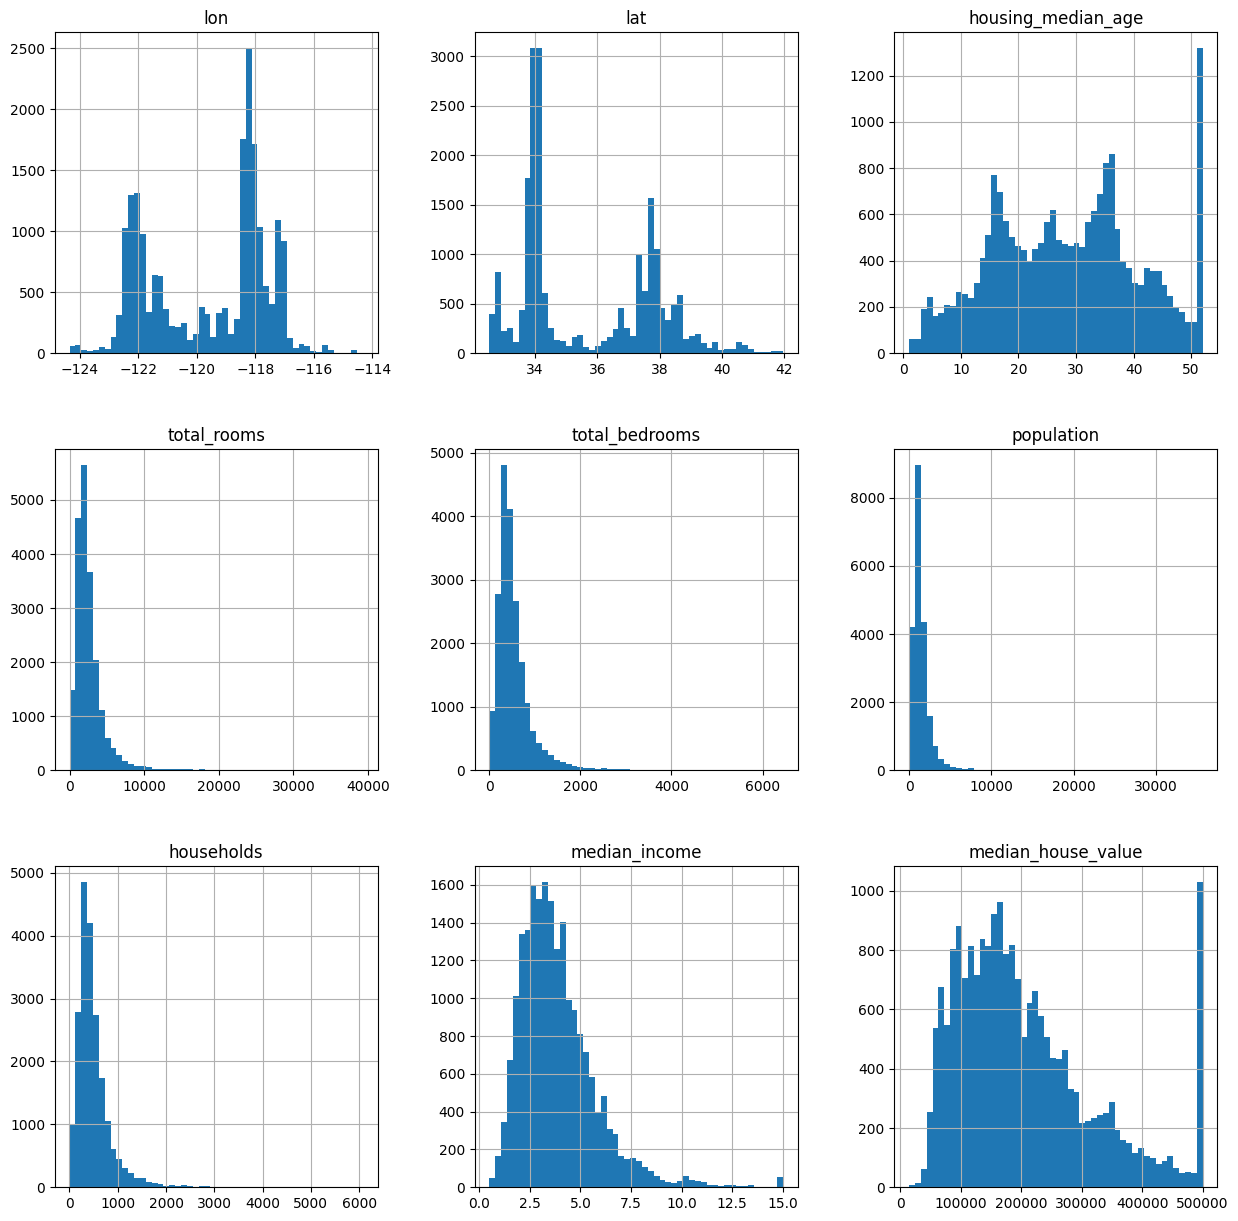

In [ ]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(15, 15))
plt.show()

Será que quanto mais perto do mar, mais antiga a habitação?

In [ ]:
housing.groupby("ocean_proximity").housing_median_age.agg(mean_median_age='mean', median_median_age='median', std_median_age = 'std', max_median_age = 'max', min_median_age = 'min').reset_index().sort_values(by='mean_median_age')

,ocean_proximity,mean_median_age,median_median_age,std_median_age,max_median_age,min_median_age
1,INLAND,24.271867,23.0,12.018020,52.0,1.0
0,<1H OCEAN,29.279225,30.0,11.644453,52.0,2.0
4,NEAR OCEAN,29.347254,29.0,11.840371,52.0,2.0
3,NEAR BAY,37.730131,39.0,13.070385,52.0,2.0
2,ISLAND,42.400000,52.0,13.164346,52.0,27.0


<Axes: xlabel='ocean_proximity', ylabel='median_income'>

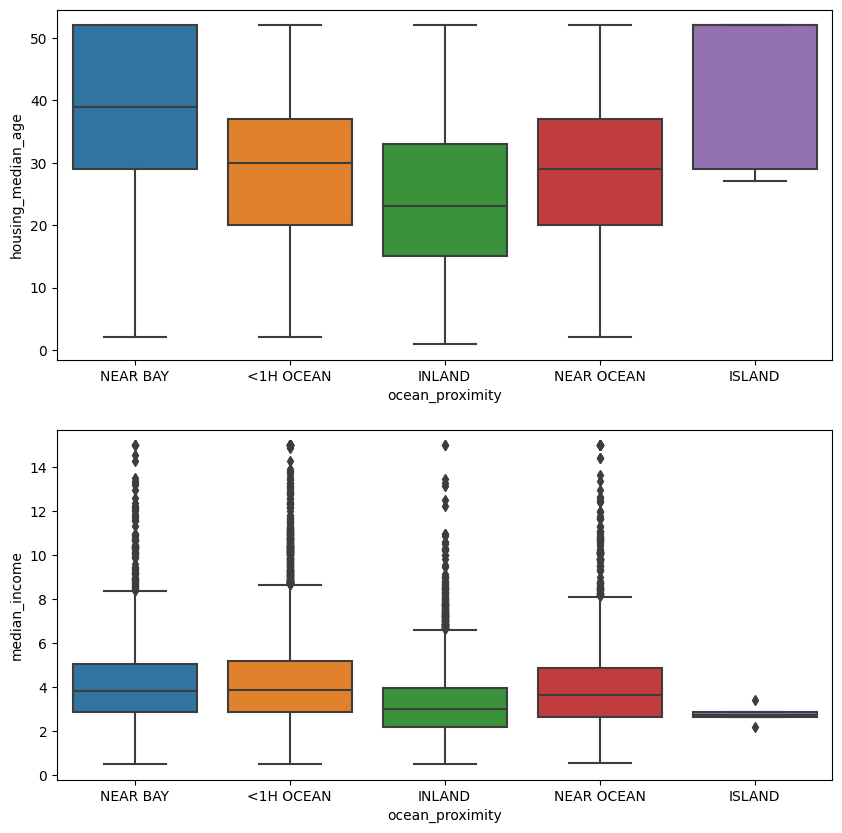

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10,10))

sns.boxplot(data=housing, x='ocean_proximity', y='housing_median_age', ax=axes[0])
sns.boxplot(data=housing, x='ocean_proximity', y='median_income', ax=axes[1])

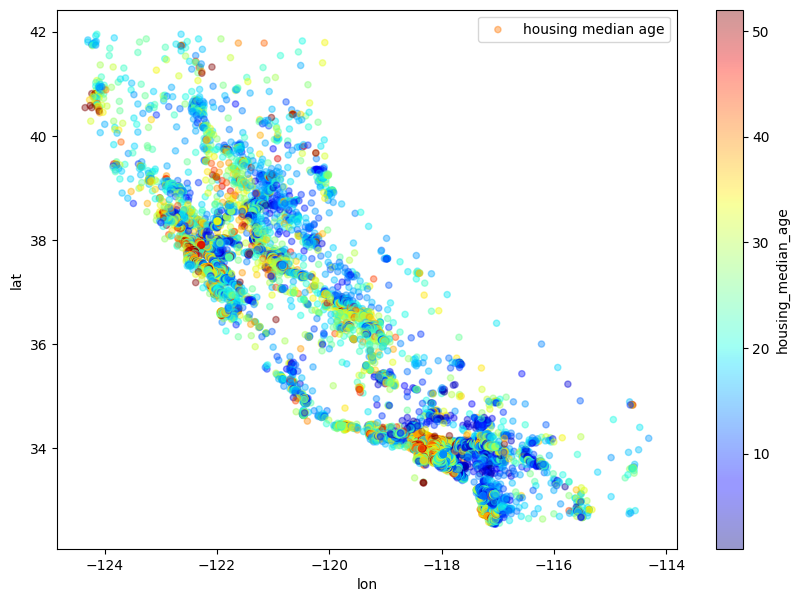

In [ ]:
housing.plot(kind="scatter", x="lon", y="lat", alpha=0.4, label="housing median age", figsize=(10,7), 
        c="housing_median_age", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

Maybe it's because the area near ocean/bay or in island, it's smaller and it's more valuable so the area already occupied is much larger.

In [ ]:
housing.groupby('ocean_proximity').agg(
    {'median_house_value': ['mean', 'median', 'std', 'sum'],
     'population': ['mean', 'median', 'std', 'sum']}
)

median_house_value                                         \
                              mean    median            std           sum   
ocean_proximity                                                             
<1H OCEAN            240084.285464  214850.0  106124.292213  2.193410e+09   
INLAND               124805.392001  108500.0   70007.908494  8.176001e+08   
ISLAND               380440.000000  414700.0   80559.561816  1.902200e+06   
NEAR BAY             259212.311790  233800.0  122818.537064  5.935962e+08   
NEAR OCEAN           249433.977427  229450.0  122477.145927  6.629955e+08   

                  population                                   
                        mean  median          std         sum  
ocean_proximity                                                
<1H OCEAN        1520.290499  1247.0  1185.848357  13889374.0  
INLAND           1391.046252  1124.0  1168.670126   9112744.0  
ISLAND            668.000000   733.0   301.691067      3340.0  
NEAR BAY         1230.317467  1033.5   885.899035   2817427.0  
NEAR OCEAN       1354.008653  1136.5  1005.563166   3598955.0

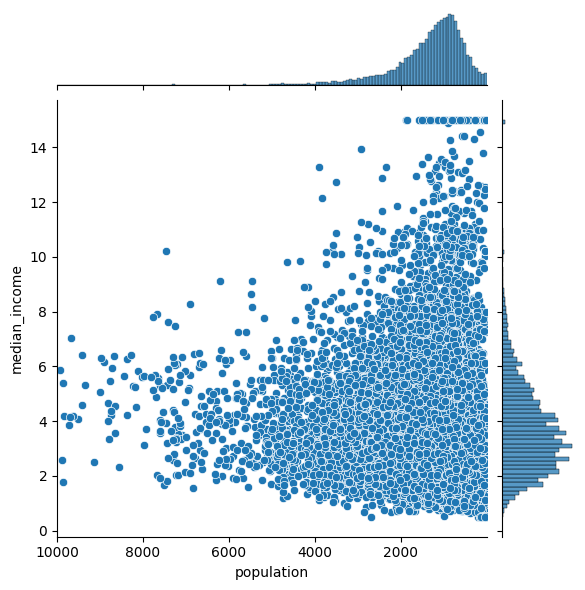

In [ ]:
sns.jointplot(data=housing, x='population', y='median_income', xlim=10000)

Doesn't look like there is a relationship between median income and population

<Axes: xlabel='ocean_proximity', ylabel='households'>

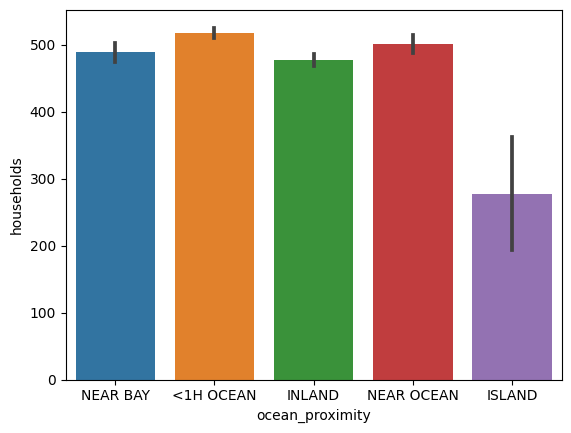

In [ ]:
sns.barplot(data=housing, x='ocean_proximity', y='households')

## **Median House Value (target) Analysis**

Será que a proximidade com o oceano influencia o valor mediano?

<Axes: xlabel='ocean_proximity', ylabel='median_house_value'>

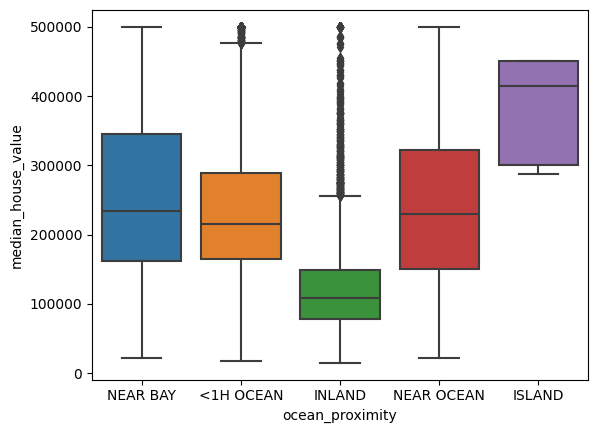

In [ ]:
sns.boxplot(data=housing, x='ocean_proximity', y='median_house_value')

<Axes: xlabel='ocean_proximity', ylabel='population'>

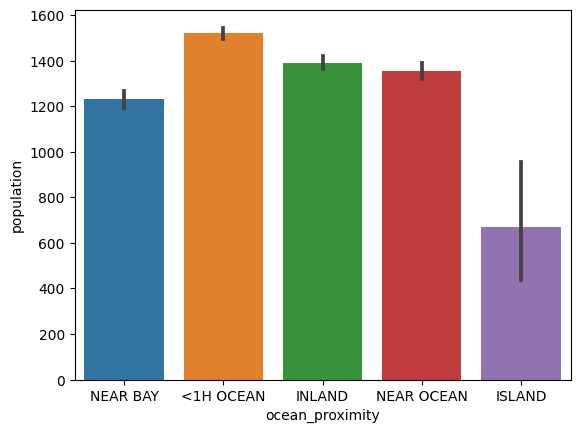

In [ ]:
sns.barplot(data=housing, x='ocean_proximity', y='population', estimator='mean')

Apparently the closer to the sea the higher the value. Houses on islands are more expensive and have little population. Income on island homes is lower.

<Axes: xlabel='lon', ylabel='lat'>

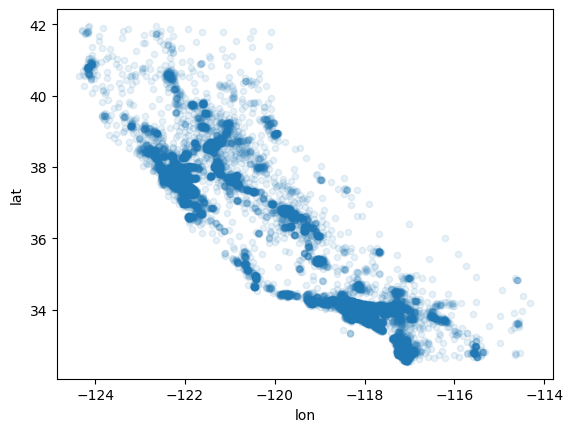

In [ ]:
housing.plot(kind="scatter", x="lon", y="lat", alpha=0.1)

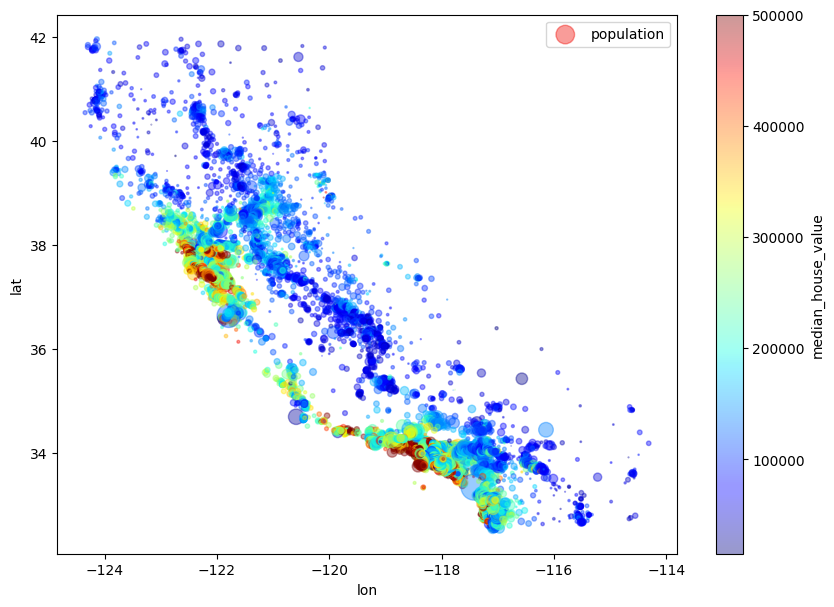

In [ ]:
housing.plot(kind="scatter", x="lon", y="lat", alpha=0.4,     
        s=housing["population"]/100, label="population", figsize=(10,7), 
        c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

There are more housing and population in the area near bay/ocean

Is there a relationship between income and the value of a housing?

<Axes: xlabel='median_income', ylabel='median_house_value'>

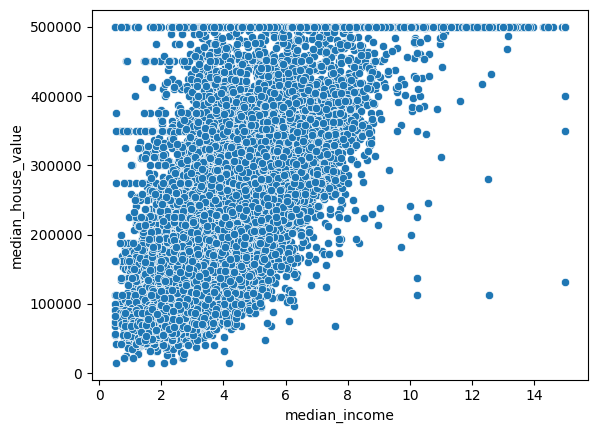

In [ ]:
sns.scatterplot(data=housing, x='median_income', y='median_house_value')

Parece haver uma relação positiva entre os features

<Figure size 1500x1000 with 0 Axes>

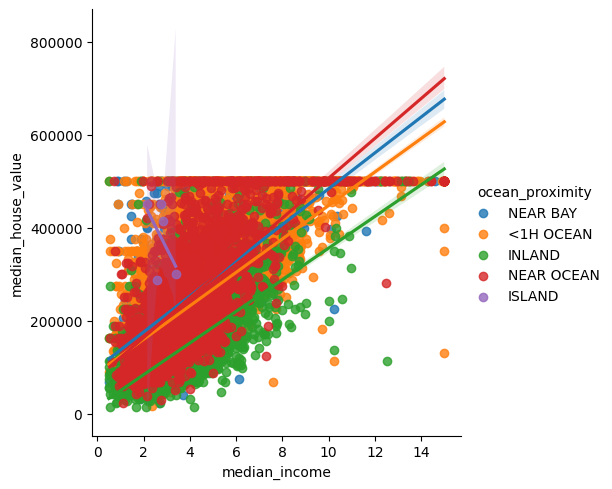

In [ ]:
plt.figure(figsize=(15, 10))
sns.lmplot(data=housing, x='median_income', y='median_house_value', hue='ocean_proximity')
plt.show()


Looks like when becomes near ocean/bay the slope is higher and the intercept too

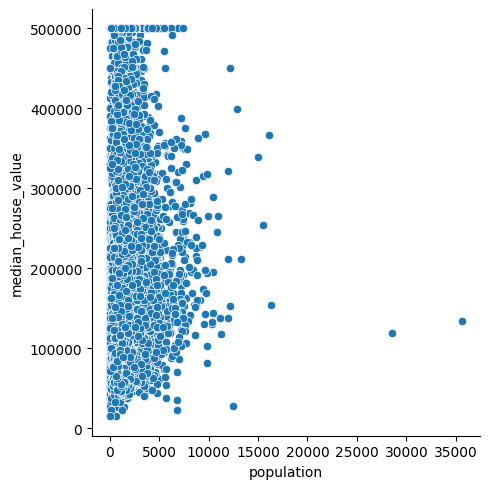

In [ ]:
sns.relplot(data=housing, x='population', y='median_house_value')

Doesn't look like there is any relationship between the population and the median_house_value.

But the map says something different... Maybe there is more population in the coast and the median house value is bigger too, but they're not related directly.

## Adding nearest city

In [ ]:
housing.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [ ]:
import geopandas as gpd

In [ ]:
geometry_housing = gpd.points_from_xy(housing['lon'], housing['lat'])
points_housing = gpd.GeoDataFrame(housing, geometry=geometry_housing)

In [ ]:
california_cities = pd.read_csv('cal_cities_lat_long.csv')
california_cities.head(5)

,Name,Latitude,Longitude
0,Adelanto,34.582769,-117.409214
1,Agoura Hills,34.153339,-118.761675
2,Alameda,37.765206,-122.241636
3,Albany,37.886869,-122.297747
4,Alhambra,34.095286,-118.127014


In [ ]:
geometry_cal = gpd.points_from_xy(california_cities['Longitude'], california_cities['Latitude'])
points_cal = gpd.GeoDataFrame(california_cities, geometry=geometry_cal)

In [ ]:
joined_data = gpd.sjoin_nearest(points_housing,points_cal, how='left', distance_col='distance_nearest_city')
joined_data

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,geometry,index_right,Name,Latitude,Longitude,distance_nearest_city
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,POINT (-122.23000 37.88000),34,Berkeley,37.871592,-122.272747,0.043566
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,POINT (-122.22000 37.86000),303,Piedmont,37.824372,-122.231636,0.037480
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,POINT (-122.24000 37.85000),303,Piedmont,37.824372,-122.231636,0.026958
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,POINT (-122.25000 37.85000),34,Berkeley,37.871592,-122.272747,0.031363
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,POINT (-122.25000 37.85000),34,Berkeley,37.871592,-122.272747,0.031363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,POINT (-121.09000 39.48000),269,Nevada City,39.261561,-121.016058,0.230614
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,POINT (-121.21000 39.49000),269,Nevada City,39.261561,-121.016058,0.299663
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,POINT (-121.22000 39.43000),154,Grass Valley,39.219061,-121.061061,0.264115
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,POINT (-121.32000 39.43000),286,Oroville,39.513775,-121.556358,0.250766


In [ ]:
joined_data = joined_data.rename(columns={'Name': 'nearest_city'})

In [ ]:
get_na(joined_data)

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,geometry,index_right,nearest_city,Latitude,Longitude,distance_nearest_city
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY,POINT (-122.16000 37.77000),359,San Leandro,37.724931,-122.156078,0.045239
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY,POINT (-122.17000 37.75000),359,San Leandro,37.724931,-122.156078,0.028675
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY,POINT (-122.28000 37.78000),277,Oakland,37.804364,-122.271114,0.025934
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY,POINT (-122.24000 37.75000),2,Alameda,37.765206,-122.241636,0.015294
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY,POINT (-122.10000 37.69000),164,Hayward,37.668819,-122.080797,0.028590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,NEAR OCEAN,POINT (-119.19000 34.20000),287,Oxnard,34.197506,-119.177053,0.013185
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,NEAR OCEAN,POINT (-119.18000 34.19000),287,Oxnard,34.197506,-119.177053,0.008064
20372,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN,POINT (-118.88000 34.17000),443,Westlake Village,34.145839,-118.805647,0.078180
20460,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0,<1H OCEAN,POINT (-118.75000 34.29000),391,Simi Valley,34.269447,-118.781483,0.037598


In [ ]:
jhousing=joined_data.drop(columns=['geometry', 'index_right','Latitude','Longitude'])

In [ ]:
get_na(jhousing)

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,nearest_city,distance_nearest_city
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY,San Leandro,0.045239
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY,San Leandro,0.028675
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY,Oakland,0.025934
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY,Alameda,0.015294
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY,Hayward,0.028590
...,...,...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,NEAR OCEAN,Oxnard,0.013185
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,NEAR OCEAN,Oxnard,0.008064
20372,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN,Westlake Village,0.078180
20460,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0,<1H OCEAN,Simi Valley,0.037598


In [ ]:
jhousing

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,nearest_city,distance_nearest_city
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,Berkeley,0.043566
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,Piedmont,0.037480
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,Piedmont,0.026958
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,Berkeley,0.031363
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,Berkeley,0.031363
...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,Nevada City,0.230614
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,Nevada City,0.299663
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,Grass Valley,0.264115
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,Oroville,0.250766


## EDA: Part 2

In [ ]:
jhousing.nearest_city.value_counts()

San Francisco    408
San Fernando     369
San Diego        353
San Jose         306
Los Angeles      290
                ... 
McFarland          4
Montague           4
Tulelake           2
Amador City        2
Dorris             1
Name: nearest_city, Length: 458, dtype: int64

In [ ]:
groupby_nearest_city = jhousing.groupby('nearest_city').agg({"median_income":'median', "median_house_value":'median'}).sort_values(by='median_income')
groupby_nearest_city

,median_income,median_house_value
nearest_city,,
Huron,1.50860,64700.0
Dorris,1.74000,44000.0
Calipatria,1.77270,50000.0
Vernon,1.81055,109800.0
Needles,1.82000,50000.0
...,...,...
Malibu,7.91840,500001.0
Palos Verdes Estates,8.08975,500001.0
Rancho Palos Verdes,8.28310,500001.0


In [ ]:
groupby_nearest_city.corr()

,median_income,median_house_value
median_income,1.000000,0.833427
median_house_value,0.833427,1.000000


In [ ]:
joined_data

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,geometry,index_right,nearest_city,Latitude,Longitude,distance_nearest_city
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,POINT (-122.23000 37.88000),34,Berkeley,37.871592,-122.272747,0.043566
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,POINT (-122.22000 37.86000),303,Piedmont,37.824372,-122.231636,0.037480
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,POINT (-122.24000 37.85000),303,Piedmont,37.824372,-122.231636,0.026958
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,POINT (-122.25000 37.85000),34,Berkeley,37.871592,-122.272747,0.031363
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,POINT (-122.25000 37.85000),34,Berkeley,37.871592,-122.272747,0.031363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,POINT (-121.09000 39.48000),269,Nevada City,39.261561,-121.016058,0.230614
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,POINT (-121.21000 39.49000),269,Nevada City,39.261561,-121.016058,0.299663
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,POINT (-121.22000 39.43000),154,Grass Valley,39.219061,-121.061061,0.264115
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,POINT (-121.32000 39.43000),286,Oroville,39.513775,-121.556358,0.250766


0.03681592406959757 0.21479600866014117


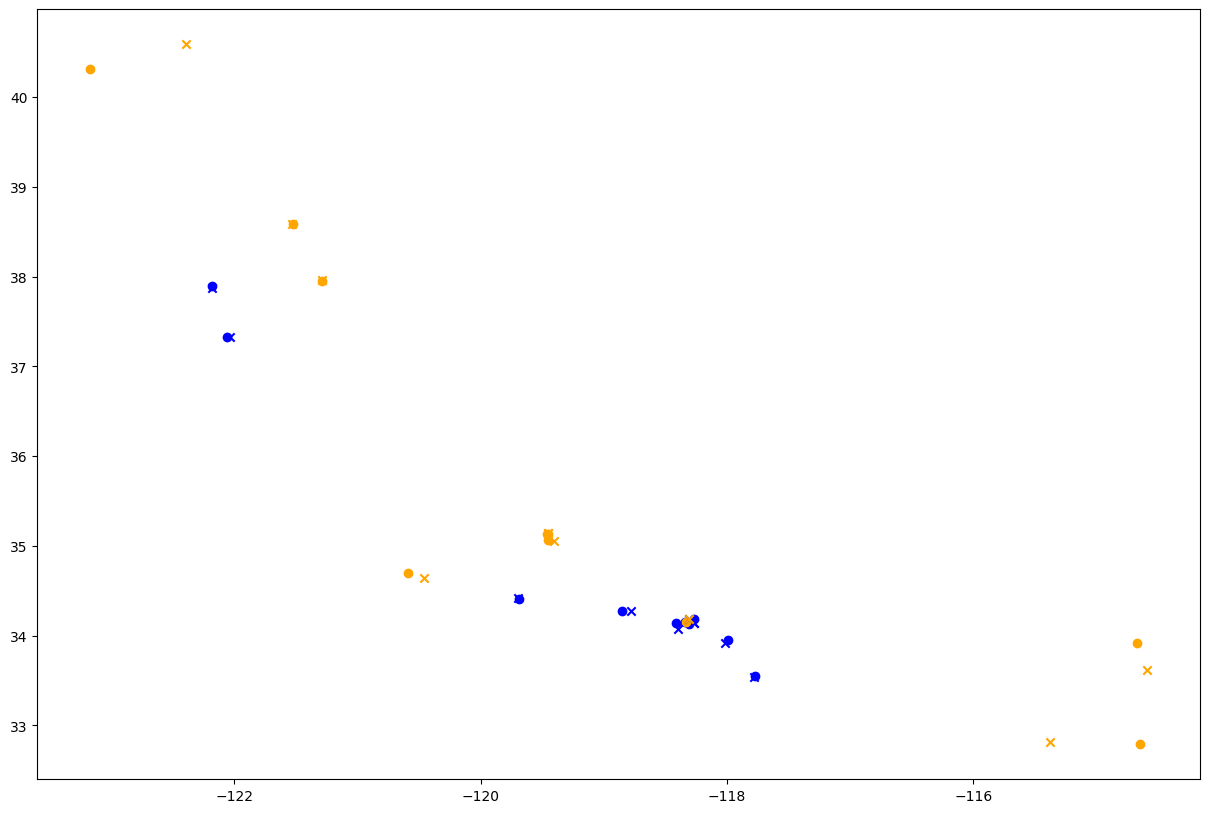

In [ ]:
costliest_housing = joined_data.drop_duplicates(subset='median_house_value', keep='last').nlargest(10, 'median_house_value')
cheapest_housing = joined_data.drop_duplicates(subset='median_house_value', keep='last').nsmallest(10, 'median_house_value')

print(costliest_housing['distance_nearest_city'].mean(), cheapest_housing['distance_nearest_city'].mean())

plt.figure(figsize=(15, 10))

plt.scatter(costliest_housing['lon'], costliest_housing['lat'], c='blue', marker='o', label='10 Costliest Housing Prices')
plt.scatter(cheapest_housing['lon'], cheapest_housing['lat'], c='orange', marker='o', label='10 Cheapest Housing Prices')

plt.scatter(costliest_housing['Longitude'], costliest_housing['Latitude'], c='blue', marker='x', label='Nearest Cities')
plt.scatter(cheapest_housing['Longitude'], cheapest_housing['Latitude'], c='orange', marker='x', label='Nearest Cities')


## Median Income vs Median House Value comparison
 Let's see how the median_income and the median_house_value is related in the largest median median_house_value counties compared to the smallest median median_house_value counties:

In [ ]:
lgst_values_counties = groupby_nearest_city.nlargest(3, 'median_house_value').reset_index().nearest_city.to_list()
lgst_values_counties

['Brentwood', 'Newport Beach', 'Rolling Hills Estates']

In [ ]:
smlst_values_counties = groupby_nearest_city.nsmallest(3, 'median_house_value').reset_index().nearest_city.to_list()
smlst_values_counties

['Tulelake', 'Dorris', 'Calipatria']

In [ ]:
jhousing.query(f"nearest_city in {lgst_values_counties+smlst_values_counties}")

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,nearest_city,distance_nearest_city
2665,-115.52,33.12,38.0,1327.0,262.0,784.0,231.0,1.8793,60800.0,INLAND,Calipatria,0.008094
2666,-115.52,33.13,18.0,1109.0,283.0,1006.0,253.0,2.1630,53400.0,INLAND,Calipatria,0.007319
2667,-115.51,33.12,21.0,1024.0,218.0,890.0,232.0,2.1010,46700.0,INLAND,Calipatria,0.006969
2668,-115.46,33.19,33.0,1234.0,373.0,777.0,298.0,1.0000,40000.0,INLAND,Calipatria,0.084144
2669,-115.51,33.24,32.0,1995.0,523.0,1069.0,410.0,1.6552,43300.0,INLAND,Calipatria,0.114478
...,...,...,...,...,...,...,...,...,...,...,...,...
10817,-117.95,33.63,17.0,6745.0,1547.0,2688.0,1535.0,3.9917,271600.0,<1H OCEAN,Newport Beach,0.023795
11439,-117.98,33.61,17.0,2054.0,291.0,836.0,288.0,6.8939,383900.0,NEAR OCEAN,Newport Beach,0.051825
12443,-115.22,33.54,18.0,1706.0,397.0,3424.0,283.0,1.6250,53500.0,INLAND,Calipatria,0.508189
18823,-121.62,41.78,40.0,3272.0,663.0,1467.0,553.0,1.7885,43500.0,INLAND,Tulelake,0.226452


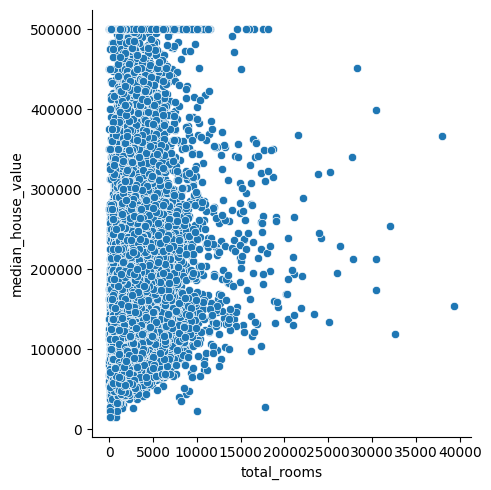

In [ ]:
sns.relplot(data=jhousing, x='total_rooms', y='median_house_value')

In [ ]:
jhousing.corr()['median_house_value']

C:\Users\E17740284769\AppData\Local\Temp\ipykernel_8852\3865976636.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  jhousing.corr()['median_house_value']


lon                     -0.042146
lat                     -0.146742
housing_median_age       0.104800
total_rooms              0.134136
total_bedrooms           0.049087
population              -0.024952
households               0.065149
median_income            0.688345
median_house_value       1.000000
distance_nearest_city   -0.143746
Name: median_house_value, dtype: float64

In [ ]:
copy = jhousing.copy()

In [ ]:
copy['rooms_per_household'] =  copy['total_rooms'] / copy['households']
copy['population_per_household'] = copy['population'] / copy['households']
copy['bedrooms_per_room'] = copy['total_bedrooms'] / copy['total_rooms']

In [ ]:
copy.select_dtypes(include=np.number).corr()['median_house_value']

lon                        -0.042146
lat                        -0.146742
housing_median_age          0.104800
total_rooms                 0.134136
total_bedrooms              0.049087
population                 -0.024952
households                  0.065149
median_income               0.688345
median_house_value          1.000000
distance_nearest_city      -0.143746
rooms_per_household         0.153110
population_per_household   -0.023702
bedrooms_per_room          -0.257254
Name: median_house_value, dtype: float64

## Preparing for regression

In [ ]:
data = housing.drop(columns='geometry')

In [ ]:
data

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [ ]:
X_data = data.drop(columns='median_house_value')
y = data['median_house_value']

In [ ]:
cat_features = ["ocean_proximity", "nearest_city"]
numeric_features = list(set(X_data.columns.to_list()) - set(cat_features) - set(['lat', 'lon']))

In [ ]:
numeric_features

['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'households',
 'population',
 'median_income']

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs 
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do 
    def transform(self, X, y=None):
        geometry_housing = gpd.points_from_xy(X['lon'], X['lat'])
        points_housing = gpd.GeoDataFrame(X, geometry=geometry_housing)

        california_cities = pd.read_csv('cal_cities_lat_long.csv')
        geometry_cal = gpd.points_from_xy(california_cities['Longitude'], california_cities['Latitude'])
        points_cal = gpd.GeoDataFrame(california_cities, geometry=geometry_cal)

        joined_data = gpd.sjoin_nearest(points_housing, points_cal, how='left', distance_col='distance_nearest_city')
        joined_data = joined_data.rename(columns={'Name': 'nearest_city'})

        X = joined_data.drop(columns=['lon','lat','geometry', 'index_right','Latitude','Longitude'])    

        X = X[~X.index.duplicated(keep='first')]
        

        X['rooms_per_household'] = X.total_rooms / X.households
        X['population_per_household'] = X.population / X.households

        if self.add_bedrooms_per_room:
            X['bedrooms_per_room'] = X.total_bedrooms / X.total_rooms
            
        return X
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False) 
#housing_extra_attribs = attr_adder.transform(housing.values)

In [ ]:
num_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(f_classif, k=4))
    ])

cat_transformer = Pipeline(
    steps=[('encoder', OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, cat_features)
    ])

In [ ]:
reg = Pipeline(
    steps=[('combiner', CombinedAttributesAdder(add_bedrooms_per_room=False)), ('preprocessor', preprocessor), ('classifier', LinearRegression())]
)

X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.3, random_state=42)

In [ ]:
reg.fit(X_train, y_train)

#print(f"model score: {reg.score(X_test, y_test)}")

Pipeline(steps=[('combiner',
                 CombinedAttributesAdder(add_bedrooms_per_room=False)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('selector',
                                                                   SelectKBest(k=4))]),
                                                  ['housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'households', 'population',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity',
                                                   'nearest_city'])])),
                ('classifier', LinearRegression())])

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
scores = cross_val_score(reg, X_test, y_test, cv=12, scoring='neg_mean_squared_error')
reg_rmse_scores = np.sqrt(-scores)

In [ ]:
print(f"{reg_rmse_scores.mean():.2f} error with a standard deviation of {reg_rmse_scores.std():.2f}")

54222.91 error with a standard deviation of 2571.52


In [ ]:
reg

Pipeline(steps=[('combiner',
                 CombinedAttributesAdder(add_bedrooms_per_room=False)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('selector',
                                                                   SelectKBest(k=4))]),
                                                  ['housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'households', 'population',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity',
                                                   'nearest_city'])])),
                ('classifier', LinearRegression())])

In [ ]:
prediction = reg.predict(X_test)

<Axes: ylabel='median_house_value'>

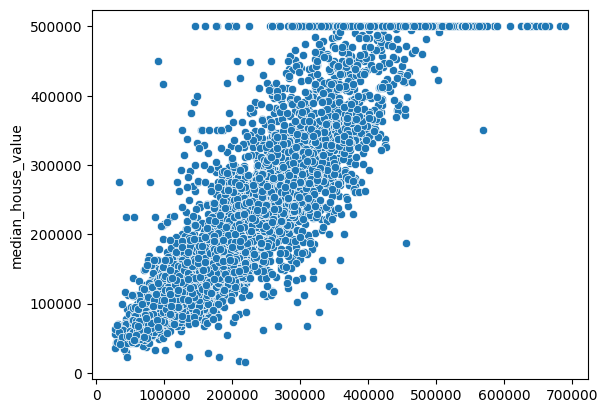

In [ ]:
sns.scatterplot(x=prediction, y = y_test)

In [ ]:
reg

Pipeline(steps=[('combiner',
                 CombinedAttributesAdder(add_bedrooms_per_room=False)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('selector',
                                                                   SelectKBest(k=4))]),
                                                  ['housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'households', 'population',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity',
                                                   'nearest_city'])])),
                ('classifier', LinearRegression())])

In [ ]:
import pickle

pickle.dump(reg, open('reg.sav', 'wb'))

In [40]:
import folium
from geopy.geocoders import Nominatim

# Define boundaries of California
# Define the boundaries of California
min_lon, min_lat = -124.4820, 32.5295
max_lon, max_lat = -114.1315, 42.0095

# Initialize map with Stamen Terrain tiles limited to California bounds
map_ca = folium.Map(
    location=[37.7749, -122.4194],
    zoom_start=6)

map_ca.max_bounds = True
map_ca.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])

# Ask user for an address
address = input("Enter an address to add to the map: ")

# Use geopy to get latitude and longitude from the address
geolocator = Nominatim(user_agent="marking_address_california")
location = geolocator.geocode(address)
lat, lon = location.latitude, location.longitude

# Add marker to the map
folium.Marker(
    location=[lat, lon],
    popup=address,
    icon=folium.Icon(color='red')
).add_to(map_ca)

# Display map
map_ca


In [ ]:
def get_coords(address: str, geolocator):
    return geolocator.geocode(address)

def plot_marker(map: folium.Map, coords, address=None):
    marker = folium.Marker(location = coords, popup=address, icon=folium.Icon(color='red'))
    marker.add_to(map)

def create_map():
    # Define the boundaries of California
    min_lat, min_lon = 32.5295, -124.4820
    max_lat, max_lon = 42.0095, -114.1315

    # Create a map centered on California
    map_ca = folium.Map(location=[37.7749, -122.4194], zoom_start=6, min_lat=min_lat, min_lon=min_lon, max_lat=max_lat, max_lon=max_lon, no_wrap=True, max_bounds=True)

    return map_ca

In [43]:
import folium
from geopy.geocoders import Nominatim

# Define the boundaries of California
min_lat, min_lon = 32.5295, -124.4820
max_lat, max_lon = 42.0095, -114.1315

# Create a map centered on California
map_ca = folium.Map(location=[37.7749, -122.4194], zoom_start=6, min_lat=min_lat, min_lon=min_lon, max_lat=max_lat, max_lon=max_lon, no_wrap=True, max_bounds=True)


# Get the location from an address input
geolocator = Nominatim(user_agent="app")
location = geolocator.geocode("Los Angeles, California")

# Add a marker at the specified location
folium.Marker(location=[location.latitude, location.longitude], popup="Los Angeles").add_to(map_ca)

# Display the map
map_ca
